<a href="https://colab.research.google.com/github/blnblnbln/College_Statistics_with_Python/blob/main/Convolution_testeo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Fase 1: Importar librerias

In [ ]:
#from google.colab import drive#conectar al drive con la información
#drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import astropy
import numpy as np
import scipy
import numpy
#!pip install pyspeckit #una vez usado comentar esta linea de codigo
import pyspeckit
#import sedfitter
import zipfile
import os
import re
#from astropy.extern import six
#from sedfitter.filter import Filter
#from sedfitter import fit
import matplotlib.pyplot as plt
#from sklearn import preprocessing
from astropy.table import QTable,Table,Column



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.4 MB 1.4 MB/s 
  Created wheel for pyspeckit: filename=pyspeckit-1.0.1-py3-none-any.whl size=25335106 sha256=0feba6200792cccfd5cc2d4305a67a808e41bfd54ca6ec7bc4e6c631f09583bd
  Stored in directory: /root/.cache/pip/wheels/30/75/d8/bfafb80a8acdbd1a61d89a8b15cf1dd66c1fc6518ea906561f
Successfully built pyspeckit


Fase 2: Funciones


In [ ]:
def Filterdat(lista): #filtrar datos de directorios por ".dat"
    return [name for name in lista if re.search(r'dat', name)]

def colxfil(mat): #en una tabla, o matriz, cambiar filas por columnas
    num=[i for i in range(len(mat[0]))]
    aux=[]
    mat2=[]
    for pos in num:
        aux=[]
        for lista in mat:
            aux.append(lista[pos])
        
        mat2.append(aux)
    return mat2

#def norm(lista): #normalizacion de datos por preprocessing
#    return preprocessing.normalize(lista)

def norm(lista): #normalización de datos por maximos y minimos
    a=[]
    for f in lista:
        a.append((f-min(lista))/(max(lista)-min(lista)))
    return a


def unique(lista): #devuelve una lista con datos unicos, los repetidos fuera
    unicos=[]
    for i in lista:
        if i not in unicos:
            unicos.append(i)
    return unicos

def recta(punto1,punto2,evaluar): #crea valores entre 2 puntos en funcion de un conjunto externo
    x1=punto1[0]
    y1=punto1[1]
    x2=punto2[0]
    y2=punto2[1]
    if x2!=x1:
        m=(y2-y1)/(x2-x1)
    if x2==x1:
        pass
    c=y1-(m*x1)
    return [(m*x)+c for x in evaluar]
    

def integrar(datos_entrada,datos_respuesta,limite_minimo,limite_maximo,cantidad_sumas): #terminado y por probar en datos reales

    delta=(limite_maximo-limite_minimo)
    divisiones=float(delta/cantidad_sumas)
    
    
    dominio_1=float(limite_minimo)
    dominio=[dominio_1]
    aprox=len(str(cantidad_sumas))
    while round(float(dominio_1),aprox)!=round(float(limite_maximo),aprox): #funciona generando las divisiones de base n, guardado en la lista dominio.
        dominio_1+=divisiones
        dominio.append(round(dominio_1,aprox))
    #return dominio
    
    coordenadas=[]
    for ejex,ejey in zip(datos_entrada,datos_respuesta): #guarda los conjuntos de coordendas que entran.
        if ejex >= min(dominio) and ejex <= max(dominio):
            for value in dominio:
                if round(float(value))==float(ejex):
                    coordenadas.append([ejex,ejey])
    #return unique(coordenadas)
    
    coordenadas2=unique(coordenadas)
    #indices=0
    
    valores=[]
    dom=[]
    respuestas=[]
    
    for contador in range(0,len(coordenadas2)-1): #correctamente se separan las rectas, y todos los valores en x tienen respuesta en el eje y.
        datos_x=[]
        puntos=[]
        for valores in dominio:
            puntos=[coordenadas2[contador],coordenadas2[contador+1]]
            if valores>=coordenadas2[contador][0] and valores <=coordenadas2[contador+1][0]:
                datos_x.append(valores)
                
        dom.append(datos_x)
        aux=recta(puntos[0],puntos[1],datos_x)
        respuestas.append(aux)    
    #return (dom,respuestas)
    salida=[]
    for recta_x,recta_y in zip(dom,respuestas): #salida correcta.
        c=0
        aux=[]
        while c!=(len(recta_x)-1):
            base=recta_x[c+1]-recta_x[c]
            altura=recta_y[c] ###revisar si el modelo creado sirve y para cual respuesta #c+1, acercamiento superior; c, acercamiento innferior.
            aux.append(base*altura)
            c+=1
        salida.append(aux)
    #return salida
    
    integrado=0
    for lista in salida: #sumatoria final; integración.
        integrado+=sum(lista)
    return integrado
  



In [ ]:
def convolution(espectro,filtro,cantidad_sumas): #ingresan 2 tablas de 2 columnas y m,n filas cada uno, m y n pueden ser iguales o no
    spectra_wl=[]
    spectra_flux=[]
    
    for pair in espectro:
        spectra_wl.append(pair[0])
        spectra_flux.append(pair[1])
        
    filter_wl=[]
    filter_flux=[]
    filter_mixto=[]
    for pair in filtro:
        filter_wl.append(pair[0])
        filter_flux.append(pair[1])
        filter_mixto.append([pair[0],pair[1]])
        
    limite_maximo=max(filter_wl)
    limite_minimo=min(filter_wl)
    
    delta=(limite_maximo-limite_minimo)
    divisiones=float(delta/cantidad_sumas)

    ##########################
    #mismo dominio para ambos#
    ##########################
    dominio_1=float(limite_minimo)
    dominio=[dominio_1]
    aprox=len(str(cantidad_sumas))
    while round(float(dominio_1),aprox)!=round(float(limite_maximo),aprox): #funciona generando las divisiones de base n, guardado en la lista dominio.
        dominio_1+=divisiones
        dominio.append(round(dominio_1,aprox))

    #return max(dominio) #checked
    
    #################
    #spectral coords#
    #################
    coords_spectra=[]
    for ejex,ejey in zip(spectra_wl,spectra_flux): #guarda los conjuntos de coordendas que entran.
        if ejex >= min(dominio) and ejex <= max(dominio):
            for value in dominio:
                if round(float(value),aprox)==round(float(ejex),aprox):
                    coords_spectra.append([ejex,ejey])

    coordenadas2=unique(coords_spectra)
    spectra_limitada_wl=[pair[0] for pair in coordenadas2]
    spectra_limitada_flux=[pair[1] for pair in coordenadas2]
    
    
    
    ###############
    #filtro coords#
    ###############
    coords_filtro=[]
    for ejex,ejey in zip(filter_wl,filter_flux):
        for value in dominio:
            if round(float(value),aprox)==round(float(ejex),aprox):
                coords_filtro.append([ejex,ejey])
                
    coordenadas3=unique(coords_filtro)
    filtro_limitada_wl=[pair[0] for pair in coordenadas3]
    filtro_limitada_flux=[pair[1] for pair in coordenadas3]

    
    
    ####################
    #espectro respuesta#
    ####################
    S_wl=[]
    S_respuestas=[]
    for contador in range(0,len(coordenadas2)-1): #correctamente se separan las rectas, y todos los valores en x tienen respuesta en el eje y.
        datos_x=[]
        puntos=[]
        for valores in dominio:
            puntos=[coordenadas2[contador],coordenadas2[contador+1]]
            if valores>=coordenadas2[contador][0] and valores <=coordenadas2[contador+1][0]:
                datos_x.append(valores)   
        S_wl.append(datos_x)
        aux=recta(puntos[0],puntos[1],datos_x)
        S_respuestas.append(aux)
     
    Swl_cont=[]
    SR_cont=[]
    for wl in S_wl:
        Swl_cont+=wl
    for rfl in S_respuestas:
        SR_cont+=rfl
        
       
    
    ##################
    #filtro respuesta#
    ##################
    F_wl=[]
    F_respuestas=[]
    for contador in range(0,len(coordenadas3)-1):
        datos_x=[]
        puntos=[]
        for valores in dominio:
            puntos=[coordenadas3[contador],coordenadas3[contador+1]]
            if valores >= puntos[0][0] and valores <= puntos[1][0]:
                datos_x.append(valores)
        F_wl.append(datos_x)
        aux2=recta(puntos[0],puntos[1],datos_x)
        F_respuestas.append(aux2)
    
    Fwl_cont=[]
    FR_cont=[]
    for wl in F_wl:
        Fwl_cont+=wl
    for rfl in F_respuestas:
        FR_cont+=rfl
    
    ###############################################################
    #ver el minimo en el flujo para cada valor de longitud de onda#
    ###############################################################
    espectro_final=[]
    for s,f in zip(SR_cont,FR_cont):
        aux=min(s,f)
        espectro_final.append(aux)
    #return [Fwl_cont,FR_cont,espectro_final]


    convol=[]
    c=0
    aux=[]
    while c!=(len(Swl_cont)-1):
        base=Swl_cont[c+1]-Swl_cont[c]
        altura=espectro_final[c] ###revisar si el modelo creado sirve y para cual respuesta #c+1, acercamiento superior; c, acercamiento innferior.
        convol.append(base*altura)
        c+=1
    convolucion=sum(convol)
    return [dominio,espectro_final,convolucion]

In [ ]:

print(os.listdir('drive/MyDrive/Taller_de_investigación'))
HUB='drive/MyDrive/Taller_de_investigación' #usar como base para ir a los filtros o los espectros


['SC2', 'splus_filters-master']


Fase 3: Filtros (datos y normalización)

In [ ]:
filtros=os.listdir(f'{HUB}/splus_filters-master')
Filtros=(Filterdat(filtros))
paths=[f'{HUB}/splus_filters-master/'+name for name in Filtros]
#Filtros

In [ ]:
#identification of each filter
Tablas_general_filtros=[]
for value in paths:
    auxiliar1=(astropy.io.ascii.read(value))
    Tablas_general_filtros.append(auxiliar1) #12 tablas con datos de los filtros, col1: longitud de onda / col2: flujo
#Tablas_general_filtros

In [ ]:
#graficando filtros
'''
colors=['red','green','blue','cyan','magenta','brown','yellow','black','lightblue','pink','aquamarine','violet']
pedido=''
while pedido!='YES' and pedido!='NO':
    try:
        pedido=str(input('Requires legend? >')).upper()
  
    except(ValueError):
        print('Formato incorrecto')
    
for color,fil in zip(colors,Filtros):
    #print(color)
    xau=colors.index(color)
    plt.plot(np.log10(Tablas_general_filtros[xau]['col1']),Tablas_general_filtros[xau]['col2'],color)
    if pedido=='YES':
        plt.legend(Filtros)
    #print(xau)
    
    plt.title('SPLUS Filters')
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Flux?')
plt.show()
'''

"\ncolors=['red','green','blue','cyan','magenta','brown','yellow','black','lightblue','pink','aquamarine','violet']\npedido=''\nwhile pedido!='YES' and pedido!='NO':\n    try:\n        pedido=str(input('Requires legend? >')).upper()\n  \n    except(ValueError):\n        print('Formato incorrecto')\n    \nfor color,fil in zip(colors,Filtros):\n    #print(color)\n    xau=colors.index(color)\n    plt.plot(np.log10(Tablas_general_filtros[xau]['col1']),Tablas_general_filtros[xau]['col2'],color)\n    if pedido=='YES':\n        plt.legend(Filtros)\n    #print(xau)\n    \n    plt.title('SPLUS Filters')\n    plt.xlabel('Wavelength [A]')\n    plt.ylabel('Flux?')\nplt.show()\n"

In [ ]:
#Tabla continua/ Datos de filtros como una unica tabla
Tabla_continua=Table()
wave=[]
flux=[]
for table in Tablas_general_filtros:
    for value in table['col1']:
        wave.append(value)
    for value in table['col2']:
        flux.append(value)

Tabla_continua['Wavelength']=wave
Tabla_continua['Flux']=flux
#Tabla_continua #tabla de datos mixtos de todos los filtros


In [ ]:
#normalizar filtros
Tabla_continua_normalizada=Table()
maxi=max(Tabla_continua['Flux'])
mini=min(Tabla_continua['Flux'])

LogW=[]
Nflux=[]

for value in Tabla_continua:
    auxiliar1=np.log10(value['Wavelength'])
    auxiliar2=(value['Flux']-mini)/(maxi-mini)
    LogW.append(auxiliar1)
    Nflux.append(auxiliar2)

Tabla_continua_normalizada['Log Wavelength']=LogW
Tabla_continua_normalizada['Normalized Flux']=Nflux

len(Tabla_continua_normalizada['Normalized Flux']) #tabla de datos mixtos, normalizada

1619

In [ ]:
#Separación normalizado
Tablas_para_filtros=[Table() for i in range(len(Tablas_general_filtros))]
contador=0
c=0
for par,tabla in zip(Tablas_general_filtros,Tablas_para_filtros):
    contador=len(par)+c
    auxiliar_alpha=[]
    auxiliar_beta=[]
    for datos in Tabla_continua_normalizada[c:contador]:
        auxiliar_alpha.append(datos[0])
        auxiliar_beta.append(datos[1])
        c+=1
  
    tabla['Log Wavelength']=auxiliar_alpha
    tabla['Normalized Flux']=auxiliar_beta
#Tablas_para_filtros #contiene 12 tablas de los filtros bajo log y normalizados

In [ ]:
o=0
for tab in (Tablas_para_filtros):
    o+=(len(tab['Normalized Flux']))
o

1619

Fase 4: Espectros (data y normalización)

In [ ]:
datos=os.listdir(f'{HUB}/SC2')
datos=sorted(datos[1:len(datos)])


search2=''
while search2 not in datos:
    print(f'The options are: ')
    for value in datos:
        print(f'{value}')
    search2=str(input('File name: >'))
    if search2 in datos:
        pass

aux0=sorted(os.listdir(f'{HUB}/SC2/{search2}'))
dts=[]
for value in aux0:
    if value=='.DS_Store':
        continue
    dts.append(value)


subdatos=dts

print(subdatos)
ind=[subdatos.index(i)+65 for i in subdatos]
ltr=[chr(number) for number in ind]
names=[f'{search2}{letra}' for letra in ltr]


search3=''
while search3 not in ltr:
    print('Options:')
    for value,lt in zip(names,ltr):
        print(f'for {value}, mark {lt}')
    try:
        search3=str(input('Which file would you want to open? >')).upper()
    except(ValueError):
        pass
    
ind2=ltr.index(search3)
topen=f'{HUB}/SC2/{search2}/{subdatos[ind2]}'

The options are: 
fig1
fig15
fig2
fig25
fig27
fig7
fig9
File name: >fig1
['fig1a.dat.txt', 'fig1b.dat.txt', 'fig1c.dat.txt', 'fig1d.dat.txt', 'fig1e.dat.txt']
Options:
for fig1A, mark A
for fig1B, mark B
for fig1C, mark C
for fig1D, mark D
for fig1E, mark E
Which file would you want to open? >a


In [ ]:
alpha=[]
print(topen)
with open(topen,'r') as datos:
    line=datos.readlines()
    for linea in line:
        alpha.append(linea.split())
        
columns=(alpha[2][1:])
ages=columns[1:]

totaldatos=alpha[3:]
test001=colxfil(totaldatos)

wavelength=[(aux[0]) for aux in totaldatos]

por_longitud=[(aux[1:]) for aux in totaldatos] #usar este
por_edad=colxfil(por_longitud)
#print(por_longitud[0])
#print(por_edad[0])

drive/MyDrive/Taller_de_investigación/SC2/fig1/fig1a.dat.txt


In [ ]:
#Log y Normalizando el espectro
longitudes=[np.log10(float(val)) for val in wavelength]

por_longflout=[]

for lista in por_longitud:
    por_longflin=[]
    for value in lista:
        por_longflin.append((float(value)))
    por_longflout.append(por_longflin)

por_edadflout=[]

for lista in por_edad:
    por_edadflin=[]
    for value in lista:
        por_edadflin.append((float(value)))

    por_edadflout.append(por_edadflin)
Norm_spectra=[norm(edad) for edad in por_edadflout]


In [ ]:
Tabla_espectro_final=Table()

Tabla_espectro_final['Log WL']=longitudes
for names,Nedad in zip(columns[1:],Norm_spectra):
    Tabla_espectro_final[f'{names}']=Nedad

In [ ]:
Tabla_espectro_final #los dos anteriores cumplen con el mismo objetivo, los datos ahora son floats

Log WL,1Myr,2Myr,3Myr,4Myr,5Myr,6Myr,7Myr,8Myr,9Myr,10Myr,11Myr,12Myr,13Myr,14Myr,15Myr,16Myr,17Myr,18Myr,19Myr,20Myr,30Myr,40Myr,50Myr,60Myr,70Myr,80Myr,90Myr,100Myr,200Myr,300Myr,400Myr,500Myr,600Myr,700Myr,800Myr,900Myr
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.9590413923210936,0.0,0.0,0.0,0.7064498909788385,0.6904302082955798,0.7781325236326739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.9731278535996986,0.026544527601966503,0.02583450439827166,0.02714922671756532,0.7202308896307762,0.7014481798083243,0.7893730262677919,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.9822712330395684,0.05193849110792492,0.050601953419034805,0.05329737295205908,0.72996408182468,0.7093216112057473,0.7973826009317578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.9912260756924949,0.0669591935471427,0.06519974890652103,0.06855672688092956,0.73857720598214,0.7163424614742059,0.8045166983390245,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0,0.0840661199650423,0.08189259412099352,0.08621601455232895,0.7444598250232971,0.720848715174046,0.8090955833562035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0086001717619175,0.10505124087896929,0.10236011326779036,0.10778464498304817,0.7484497281256504,0.723725745016111,0.8120190520526814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0170333392987803,0.11994906219107525,0.11695744921377037,0.12323319742446881,0.7493653249373469,0.7239863517984463,0.8122796107600323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.0253058652647704,0.13435756314051098,0.13109156732145205,0.13818063974931574,0.7500999737625426,0.7239501084711012,0.8122118654961206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2.03342375548695,0.15071838621262734,0.1471355399291019,0.15514961879159142,0.7507314822354318,0.7240433055985588,0.8122743995858849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


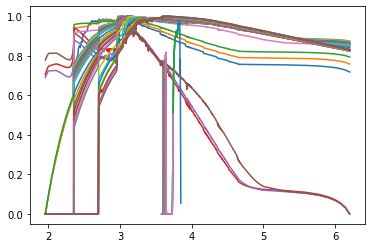

In [ ]:
#normalizando los espectros
for name in columns[1:]:
    plt.plot(Tabla_espectro_final['Log WL'],Tabla_espectro_final[name])

for filtro in Tablas_para_filtros:
    plt.plot(filtro['Log Wavelength'],filtro['Normalized Flux'])

plt.show()

In [ ]:
Tablas_espectros_por_edad=[Table() for edad in range(len(columns[1:]))]
c=0

for table,name in zip(Tablas_espectros_por_edad,columns[1:]):
    if name!='[A]':
        table['Log WL']=Tabla_espectro_final['Log WL']
        table[f'{name}']=Tabla_espectro_final[name]
#Tablas_espectros_por_edad

In [ ]:
#Filtros,columns

Cantidad_de_sumas=0
while Cantidad_de_sumas<=0:
    try:
        Cantidad_de_sumas=int(input('¿Cuantas sumas desea hacer? >'))
    except(ValueError):
        print('Valor debe ser un entero postivo')

Nombres_filtros=Filtros
Datos_por_filtro=Tablas_para_filtros
Nombres_edades=columns[1:]
Datos_por_edad=Tablas_espectros_por_edad

Valores_convolucion_por_filtro=[]


for Ename,Dedad in zip(Nombres_edades,Datos_por_edad):
    for Fname,Dfilter in zip(Nombres_filtros,Datos_por_filtro):
        crux=f'{Ename} en filtro {Fname}'
        guardar_convolucion=convolution(Dedad,Dfilter,Cantidad_de_sumas)
        Valores_convolucion_por_filtro.append([crux,guardar_convolucion])


¿Cuantas sumas desea hacer? >1000


In [ ]:
for lista in (Valores_convolucion_por_filtro):
    #print(len(lista[1][0]),len(lista[1][1]))
    print(lista[0],':',lista[1][2])

1Myr en filtro F0410.dat : 0.016193164580253678
1Myr en filtro F0430.dat : 0.016190493266808107
1Myr en filtro rSDSS.dat : 0.06421551869439673
1Myr en filtro iSDSS.dat : 0.076446822672856
1Myr en filtro zSDSS.dat : 0.0945802297099959
1Myr en filtro F0395.dat : 0.016195225755446716
1Myr en filtro gSDSS.dat : 0.05523325705909615
1Myr en filtro F0515.dat : 0.016190135666639145
1Myr en filtro F0378.dat : 0.016185497461270886
1Myr en filtro F0861.dat : 0.032709477566892124
1Myr en filtro uJAVA.dat : 0.03246936890160088
1Myr en filtro F0660.dat : 0.016193656088777434
2Myr en filtro F0410.dat : 0.016193164580253678
2Myr en filtro F0430.dat : 0.016190493266808107
2Myr en filtro rSDSS.dat : 0.0643859139891516
2Myr en filtro iSDSS.dat : 0.07689734685962281
2Myr en filtro zSDSS.dat : 0.09544674785516674
2Myr en filtro F0395.dat : 0.016195225755446716
2Myr en filtro gSDSS.dat : 0.05523822443994772
2Myr en filtro F0515.dat : 0.016190135666639145
2Myr en filtro F0378.dat : 0.016185497461270886
2Myr 

In [ ]:
#(Valores_convolucion_por_filtro)